In [ ]:
#@title Data-AI（必ず自分の名前・学籍番号を入力すること） { run: "auto", display-mode: "form" }

import urllib.request as ur
import urllib.parse as up
Name = '\u4FFA\u5AC1 \u559C\u591A\u4E4B' #@param {type:"string"}
EName = 'Oreyome Kitakore' #@param {type:"string"}
StudentID = '87654321' #@param {type:"string"}
Addrp = !cat /sys/class/net/eth0/address
Addr = Addrp[0]
url = 'https://class.west.sd.keio.ac.jp/classroll.php'
params = {'class':'dataai','name':Name,'ename':EName,'id':StudentID,'addr':Addr,
           'page':'dataai-text-G','token':'83750132'}
data = up.urlencode(params).encode('utf-8')
#headers = {'itmes','application/x-www-form-urlencoded'}
req = ur.Request(url, data=data)
res = ur.urlopen(req)

---
>「俺の嫁」という語は現代に登場したが、概念は遅くとも南北朝時代の軍記物語『太平記』（1370年ごろ）にまで遡ることができる。『太平記』伝説によれば、後醍醐天皇第一皇子の尊良親王は、『源氏物語』の一場面を描いた絵の中の美女に一目惚れし、のちにその美女と瓜二つの御匣殿という姫君に出会うまで独身であった。日本国外では、同様の概念を指すものとして「waifu」または「mai waifu」というスラングが用いられている。  
> (Wikipedia)
---

# StyleGANの応用

学習さえできれば、自在に何でもStyleGANにできる
- 顔でなくてもよい

## アニメ画像

様々な学習済みモデルが提供されており、これらも同様に潜在空間を処理できるのかを確認する

In [ ]:
%tensorflow_version 1.x

import os
#if not os.path.exists('stylegan'):
#  !wget https://keio.box.com/shared/static/tnuuo9pmwxq75b01fyocchw7z5qdtspw  -O stylegan.zip
#  !unzip stylegan.zip
!git clone https://github.com/NVlabs/stylegan.git
%cd /content/stylegan
pretrainedmodel = '2019-02-26-stylegan-faces-network-02048-016041.pkl'
if not os.path.exists(pretrainedmodel):
  !wget https://keio.box.com/shared/static/unby327cfii3h12d7gndptj11gk1rpxz  -O 2019-02-26-stylegan-faces-network-02048-016041.pkl 

Cloning into 'stylegan'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 89 (delta 0), reused 1 (delta 0), pack-reused 86
Unpacking objects: 100% (89/89), done.
/content/stylegan


In [ ]:
%tensorflow_version 1.x
%mkdir -p results

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

import pickle
import scipy
import moviepy.editor

_Gs_cache = dict()

def load_Gs(url):
    if url not in _Gs_cache:
        with open(url, 'rb') as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]

tflib.init_tf()
Gs = load_Gs(pretrainedmodel)

## seedsの要素数に相当する画像を生成する
- 適当な値を入れて生成させるとよい

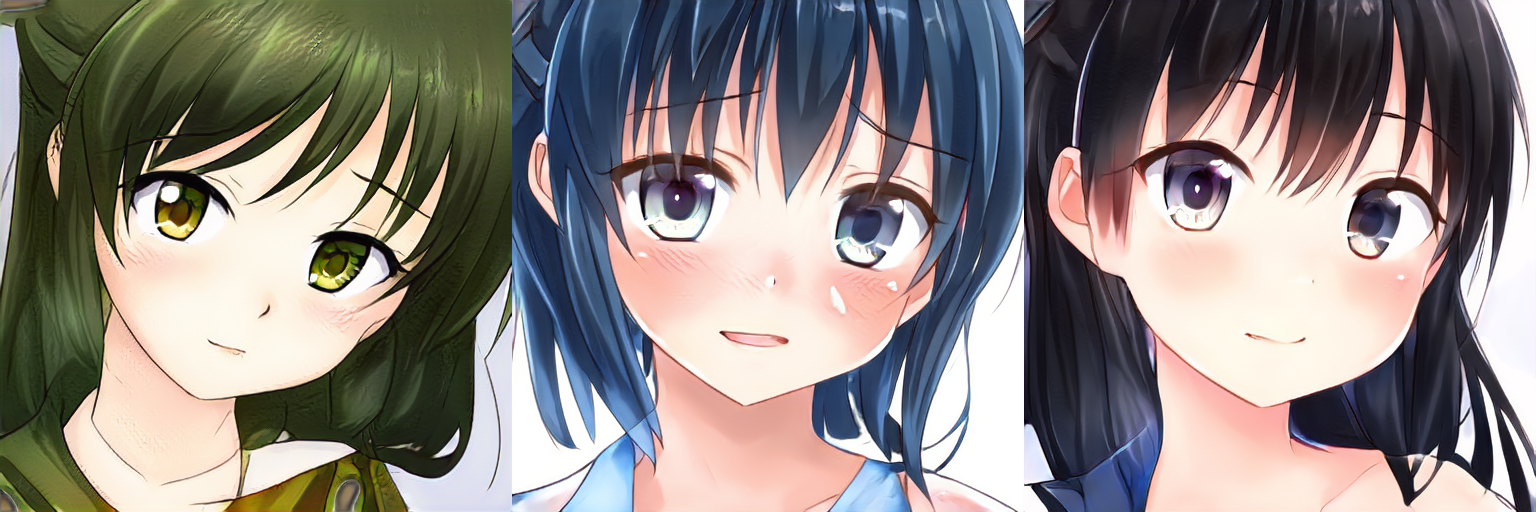

In [ ]:
tflib.init_tf()

Gs = load_Gs(pretrainedmodel)

w = 512
h = 512

seeds = [24,2424,1024]
psi  = 0.7
canvas = PIL.Image.new('RGB', (w * len(seeds), h ), 'white')
for i, seed, in enumerate(seeds):
    rnd = np.random.RandomState(seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    canvas.paste(PIL.Image.fromarray(images[0], 'RGB'), ((i) * h, 0))
canvas


## Style Mixing
colの要素で生成される画像と、rowの要素で生成される画像をミックスする

- Style Rangeについて変更してみるとよい

In [ ]:
col_seeds = [24,2424,1024,687]
row_seeds = [3546,12424]
psi = 0.7
style_range = [0, 1, 2, 3] # Corse Style 顔の向きや髪の毛の色が列で一致
#style_range = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # 継承先が逆になり行で一致
#style_range = [15] # 顔の向きや表情は変わらず髪の色が変更される

style_range = [0, 1, 2, 3]


success = True
for n in style_range:
    if n > 15:
        print("style_rangeは15以下です")
        success = False

Gs = load_Gs(pretrainedmodel)
w,h = [512, 512]
canvas = PIL.Image.new('RGB', (w * (len(col_seeds) + 1), h * (len(row_seeds) + 1)), 'black')
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=fmt, truncation_psi=0.7, minibatch_size=8)

def genarate(seed):
    rnd = np.random.RandomState(seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    return PIL.Image.fromarray(images[0], 'RGB')

def mixing(col_seed, row_seed):
    rnd = np.random.RandomState(col_seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    src_dlatents = Gs.components.mapping.run(latents, None) 

    rnd = np.random.RandomState(row_seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    dst_dlatents  = Gs.components.mapping.run(latents, None) 
    
    col_dlatents = src_dlatents
    col_dlatents[0, style_range] = dst_dlatents[0, style_range]
    col_images = Gs.components.synthesis.run(col_dlatents, randomize_noise=False,  **synthesis_kwargs)
    # images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    return PIL.Image.fromarray(col_images[0], 'RGB')

# Source images

if success:
    for i, col_seed in enumerate(col_seeds):
        im = genarate(col_seed)
        canvas.paste(im, ((i+1) * w, 0))

    # Target images
    for i, row_seed in enumerate(row_seeds):
        im = genarate(row_seed)
        canvas.paste(im, (0,  (i+1) * h))

        for j, col_seed in enumerate(col_seeds):
            im = mixing(col_seed, row_seed)
            canvas.paste(im, ((j+1)*w,  (i+1) * h))
canvas

Output hidden; open in https://colab.research.google.com to view.

中央から外れるほど、確率密度の低い領域から始まる、つまり特徴的な画像になる


In [ ]:
tflib.init_tf()

Gs = load_Gs(pretrainedmodel)

w = 512
h = 512

seed = 1024
psis = [-1.0, -0.5, 0, 0.5, 1.0]
canvas = PIL.Image.new('RGB', (w * len(psis), h ), 'white')
for i, psi in enumerate(psis):
    rnd = np.random.RandomState(seed)
    latents = rnd.randn(1, Gs.input_shape[1])
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=psi, randomize_noise=True, output_transform=fmt)
    canvas.paste(PIL.Image.fromarray(images[0], 'RGB'), ((i) * h, 0))
canvas


Output hidden; open in https://colab.research.google.com to view.

## 動画を生成する

In [ ]:
grid_size = [2, 2]
image_shrink = 1  
image_zoom = 1 
duration_sec = 10.0
smoothing_sec = 1.0 
mp4_fps = 20
mp4_codec = 'libx264' 
mp4_bitrate = '3M'
random_seed = 1024
minibatch_size = 8
mp4_file = 'results/random_grid_%s.mp4'
display_height =  400

tflib.init_tf()

Gs = load_Gs(pretrainedmodel)

num_frames = int(np.rint(duration_sec * mp4_fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents,
                [smoothing_sec * mp4_fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))

def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7,
                            randomize_noise=False, output_transform=fmt)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

movie_path_output = '/content/stylegan/' + mp4_file
display(moviepy.editor.ipython_display(movie_path_output, height=display_height, autoplay=1))

Output hidden; open in https://colab.research.google.com to view.